
# Multi-agent Reinforcement Learning With WarpDrive

* **Author:** Sunil Srinivasa (sunil.srinivasa@salesforce.com), Tian Lan (tian.lan@salesforce.com), Huan Wang (huan.wang@salesforce.com) and Stephan Zheng(stephan.zheng@salesforce.com)
* **License:** BSD 3-Clause "New" or "Revised" License
* **Generated:** 2022-04-22T04:11:41.774547

This notebook introduces multi-agent reinforcement learning (MARL) with WarpDrive (Lan et al. https://arxiv.org/abs/2108.13976). WarpDrive is a flexible, lightweight, and easy-to-use open-source framework that implements end-to-end deep MARL on GPUs. WarpDrive enables orders-of-magnitude speedups compared to CPU-GPU implementations, using the parallelization capability of GPUs and several design choices to minimize communication overhead. WarpDrive also prioritizes user-friendliness - it has utility functions to easily build MARL environments in CUDA and quality-of-life tools to run end-to-end MARL using just a few lines of code, and is compatible with PyTorch.
WarpDrive includes the following resources. code - https://github.com/salesforce/warp-drive documentation - http://opensource.salesforce.com/warp-drive/, and white paper - https://arxiv.org/abs/2108.13976.

---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/warp-drive.ipynb)

Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "ffmpeg-python" "torch>=1.6, <1.9" "torchmetrics>=0.6" "ipython[notebook]" "rl-warp-drive>=1.5.1" "pytorch-lightning>=1.4"

ERROR: Cannot install rl-warp-drive==1.5.1, rl-warp-drive==1.6, rl-warp-drive==1.6.1, rl-warp-drive==1.6.2, rl-warp-drive==1.6.3, torch<1.9 and >=1.6 and torchmetrics==0.6.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/user_guide/#fixing-conflicting-dependencies
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


**⚠️ PLEASE NOTE:**
This notebook runs on a GPU runtime. If running on Colab, choose Runtime > Change runtime type from the menu, then select `GPU` in the 'Hardware accelerator' dropdown menu.

## Introduction

This tutorial provides a demonstration of a multi-agent Reinforcement Learning (RL) training loop with [WarpDrive](https://github.com/salesforce/warp-drive). WarpDrive is a flexible, lightweight, and easy-to-use RL framework that implements end-to-end deep multi-agent RL on a single GPU (Graphics Processing Unit). Using the extreme parallelization capability of GPUs, it enables [orders-of-magnitude faster RL](https://arxiv.org/abs/2108.13976) compared to common implementations that blend CPU simulations and GPU models. WarpDrive is extremely efficient as it runs simulations across multiple agents and multiple environment replicas in parallel and completely eliminates the back-and-forth data copying between the CPU and the GPU.

We have integrated WarpDrive with the [Pytorch Lightning](https://www.pytorchlightning.ai/) framework, which greatly reduces the trainer boilerplate code, and improves training flexibility.

Below, we demonstrate how to use WarpDrive and PytorchLightning together to train a game of [Tag](https://github.com/salesforce/warp-drive/blob/master/example_envs/tag_continuous/tag_continuous.py) where multiple *tagger* agents are trying to run after and tag multiple other *runner* agents. As such, the Warpdrive framework comprises several utility functions that help easily implement any (OpenAI-)*gym-style* RL environment, and furthermore, provides quality-of-life tools to train it end-to-end using just a few lines of code. You may familiarize yourself with WarpDrive with the help of these [tutorials](https://github.com/salesforce/warp-drive/tree/master/tutorials).

We invite everyone to **contribute to WarpDrive**, including adding new multi-agent environments, proposing new features and reporting issues on our open source [repository](https://github.com/salesforce/warp-drive).

In [2]:
import logging

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
import torch
from example_envs.tag_continuous.tag_continuous import TagContinuous

# from IPython.display import HTML
from matplotlib import animation
from matplotlib.patches import Polygon
from pytorch_lightning import Trainer
from warp_drive.env_wrapper import EnvWrapper
from warp_drive.training.pytorch_lightning_trainer import CudaCallback, PerfStatsCallback, WarpDriveModule

In [3]:
_NUM_AVAILABLE_GPUS = torch.cuda.device_count()
assert _NUM_AVAILABLE_GPUS > 0, "This notebook needs a GPU to run!"

In [4]:
# Set logger level e.g., DEBUG, INFO, WARNING, ERROR.
logging.getLogger().setLevel(logging.ERROR)

## Specify a set of run configurations for your experiments

The run configuration is a dictionary comprising the environment parameters, the trainer and the policy network settings, as well as configurations for saving.

For our experiment, we consider an environment wherein $5$ taggers and $100$ runners play the game of [Tag](https://github.com/salesforce/warp-drive/blob/master/example_envs/tag_continuous/tag_continuous.py) on a $20 \times 20$ plane. The game lasts $200$ timesteps. Each agent chooses it's own acceleration and turn actions at every timestep, and we use mechanics to determine how the agents move over the grid. When a tagger gets close to a runner, the runner is tagged, and is eliminated from the game. For the configuration below, the runners and taggers have the same unit skill levels, or top speeds.

We train the agents using $50$ environments or simulations running in parallel. With WarpDrive, each simulation runs on sepate GPU blocks.

There are two separate policy networks used for the tagger and runner agents. Each network is a fully-connected model with two layers each of $256$ dimensions. We use the Advantage Actor Critic (A2C) algorithm for training. WarpDrive also currently provides the option to use the Proximal Policy Optimization (PPO) algorithm instead.

In [5]:
run_config = dict(
    name="tag_continuous",
    # Environment settings.
    env=dict(
        # number of taggers in the environment
        num_taggers=5,
        # number of runners in the environment
        num_runners=100,
        # length of the (square) grid on which the game is played
        grid_length=20.0,
        # episode length in timesteps
        episode_length=200,
        # maximum acceleration
        max_acceleration=0.1,
        # minimum acceleration
        min_acceleration=-0.1,
        # 3*pi/4 radians
        max_turn=2.35,
        # -3*pi/4 radians
        min_turn=-2.35,
        # number of discretized accelerate actions
        num_acceleration_levels=10,
        # number of discretized turn actions
        num_turn_levels=10,
        # skill level for the tagger
        skill_level_tagger=1.0,
        # skill level for the runner
        skill_level_runner=1.0,
        # each agent only sees full or partial information
        use_full_observation=False,
        # flag to indicate if a runner stays in the game after getting tagged
        runner_exits_game_after_tagged=True,
        # number of other agents each agent can see
        num_other_agents_observed=10,
        # positive reward for the tagger upon tagging a runner
        tag_reward_for_tagger=10.0,
        # negative reward for the runner upon getting tagged
        tag_penalty_for_runner=-10.0,
        # reward at the end of the game for a runner that isn't tagged
        end_of_game_reward_for_runner=1.0,
        # margin between a tagger and runner to consider the runner as 'tagged'.
        tagging_distance=0.02,
    ),
    # Trainer settings.
    trainer=dict(
        # number of environment replicas (number of GPU blocks used)
        num_envs=50,
        # total batch size used for training per iteration (across all the environments)
        train_batch_size=10000,
        # total number of episodes to run the training for (can be arbitrarily high!)
        num_episodes=50000,
    ),
    # Policy network settings.
    policy=dict(
        runner=dict(
            # flag indicating whether the model needs to be trained
            to_train=True,
            # algorithm used to train the policy
            algorithm="A2C",
            # discount rate
            gamma=0.98,
            # learning rate
            lr=0.005,
            # policy model settings
            model=dict(type="fully_connected", fc_dims=[256, 256], model_ckpt_filepath=""),
        ),
        tagger=dict(
            to_train=True,
            algorithm="A2C",
            gamma=0.98,
            lr=0.002,
            model=dict(type="fully_connected", fc_dims=[256, 256], model_ckpt_filepath=""),
        ),
    ),
    # Checkpoint saving setting.
    saving=dict(
        # how often (in iterations) to print the metrics
        metrics_log_freq=10,
        # how often (in iterations) to save the model parameters
        model_params_save_freq=5000,
        # base folder used for saving
        basedir="/tmp",
        # experiment name
        name="continuous_tag",
        # experiment tag
        tag="example",
    ),
)

## Instantiate the WarpDrive Module

In order to instantiate the WarpDrive module, we first use an environment wrapper to specify that the environment needs to be run on the GPU (via the `use_cuda` flag). Also, agents in the environment can share policy models; so we specify a dictionary to map each policy network model to the list of agent ids using that model.

In [6]:
# Create a wrapped environment object via the EnvWrapper.
# Ensure that use_cuda is set to True (in order to run on the GPU).
env_wrapper = EnvWrapper(
    TagContinuous(**run_config["env"]),
    num_envs=run_config["trainer"]["num_envs"],
    use_cuda=True,
)

# Agents can share policy models: this dictionary maps policy model names to agent ids.
policy_tag_to_agent_id_map = {
    "tagger": list(env_wrapper.env.taggers),
    "runner": list(env_wrapper.env.runners),
}

wd_module = WarpDriveModule(
    env_wrapper=env_wrapper,
    config=run_config,
    policy_tag_to_agent_id_map=policy_tag_to_agent_id_map,
    verbose=True,
)

Global seed set to 1650601003


## Visualizing an episode roll-out before training

We have created a helper function (see below) to visualize an episode rollout. Internally, this function uses the WarpDrive module's `fetch_episode_states` API to fetch the data arrays on the GPU for the duration of an entire episode. Specifically, we fetch the state arrays pertaining to agents' x and y locations on the plane and indicators on which agents are still active in the game. Note that this function may be invoked at any time during training, and it will use the state of the policy models at that time to sample actions and generate the visualization.

In [7]:
def generate_tag_env_rollout_animation(
    warp_drive_module,
    fps=25,
    tagger_color="#C843C3",
    runner_color="#245EB6",
    runner_not_in_game_color="#666666",
    fig_width=6,
    fig_height=6,
):
    assert warp_drive_module is not None
    episode_states = warp_drive_module.fetch_episode_states(["loc_x", "loc_y", "still_in_the_game"])
    assert isinstance(episode_states, dict)
    env = warp_drive_module.cuda_envs.env

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))  # , constrained_layout=True
    ax.remove()
    ax = fig.add_subplot(1, 1, 1, projection="3d")

    # Bounds
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(-0.01, 0.01)

    # Surface
    corner_points = [(0, 0), (0, 1), (1, 1), (1, 0)]

    poly = Polygon(corner_points, color=(0.1, 0.2, 0.5, 0.15))
    ax.add_patch(poly)
    art3d.pathpatch_2d_to_3d(poly, z=0, zdir="z")

    # "Hide" side panes
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # Hide grid lines
    ax.grid(False)

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    # Hide axes
    ax.set_axis_off()

    # Set camera
    ax.elev = 40
    ax.azim = -55
    ax.dist = 10

    # Try to reduce whitespace
    fig.subplots_adjust(left=0, right=1, bottom=-0.2, top=1)

    # Plot init data
    lines = [None for _ in range(env.num_agents)]

    for idx in range(len(lines)):
        if idx in env.taggers:
            lines[idx] = ax.plot3D(
                episode_states["loc_x"][:1, idx] / env.grid_length,
                episode_states["loc_y"][:1, idx] / env.grid_length,
                0,
                color=tagger_color,
                marker="o",
                markersize=10,
            )[0]
        else:  # runners
            lines[idx] = ax.plot3D(
                episode_states["loc_x"][:1, idx] / env.grid_length,
                episode_states["loc_y"][:1, idx] / env.grid_length,
                [0],
                color=runner_color,
                marker="o",
                markersize=5,
            )[0]

    init_num_runners = env.num_agents - env.num_taggers

    def _get_label(timestep, n_runners_alive, init_n_runners):
        line1 = "Continuous Tag\n"
        line2 = "Time Step:".ljust(14) + f"{timestep:4.0f}\n"
        frac_runners_alive = n_runners_alive / init_n_runners
        pct_runners_alive = f"{n_runners_alive:4} ({frac_runners_alive * 100:.0f}%)"
        line3 = "Runners Left:".ljust(14) + pct_runners_alive
        return line1 + line2 + line3

    label = ax.text(
        0,
        0,
        0.02,
        _get_label(0, init_num_runners, init_num_runners).lower(),
    )

    label.set_fontsize(14)
    label.set_fontweight("normal")
    label.set_color("#666666")

    def animate(i):
        for idx, line in enumerate(lines):
            line.set_data_3d(
                episode_states["loc_x"][i : i + 1, idx] / env.grid_length,
                episode_states["loc_y"][i : i + 1, idx] / env.grid_length,
                np.zeros(1),
            )

            still_in_game = episode_states["still_in_the_game"][i, idx]

            if still_in_game:
                pass
            else:
                line.set_color(runner_not_in_game_color)
                line.set_marker("")

        n_runners_alive = episode_states["still_in_the_game"][i].sum() - env.num_taggers
        label.set_text(_get_label(i, n_runners_alive, init_num_runners).lower())

    ani = animation.FuncAnimation(fig, animate, np.arange(0, env.episode_length + 1), interval=1000.0 / fps)
    plt.close()

    return ani

The animation below shows a sample realization of the game episode before training, i.e., with randomly chosen agent actions. The $5$ taggers are marked in pink, while the $100$ blue agents are the runners. Both the taggers and runners move around randomly and about half the runners remain at the end of the episode.

In [8]:

# anim = generate_tag_env_rollout_animation(wd_module)
# HTML(anim.to_html5_video())

## Create the Lightning Trainer

Next, we create the trainer for training the WarpDrive model. We add the `performance stats` callbacks to the trainer to view the throughput performance of WarpDrive.

In [9]:
log_freq = run_config["saving"]["metrics_log_freq"]

# Define callbacks.
cuda_callback = CudaCallback(module=wd_module)
perf_stats_callback = PerfStatsCallback(
    batch_size=wd_module.training_batch_size,
    num_iters=wd_module.num_iters,
    log_freq=log_freq,
)

# Instantiate the PytorchLightning trainer with the callbacks.
# Also, set the number of gpus to 1, since this notebook uses just a single GPU.
num_gpus = 1
num_episodes = run_config["trainer"]["num_episodes"]
episode_length = run_config["env"]["episode_length"]
training_batch_size = run_config["trainer"]["train_batch_size"]
num_epochs = num_episodes * episode_length / training_batch_size

trainer = Trainer(
    accelerator="gpu",
    devices=num_gpus,
    callbacks=[cuda_callback, perf_stats_callback],
    max_epochs=num_epochs,
)

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


In [10]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Train the WarpDrive Module

Finally, we invoke training.

Note: please scroll up to the tensorboard cell to visualize the curves during training.

In [11]:
trainer.fit(wd_module)

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:376: LightningDeprecationWarning: The `Callback.on_batch_start` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_train_batch_start` instead.
  rank_zero_deprecation(
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:376: LightningDeprecationWarning: The `Callback.on_batch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_train_batch_end` instead.
  rank_zero_deprecation(
Missing logger folder: /__w/1/s/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name | Type | Params
------------------------------
------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.29561
Policy loss                             :   -0.09944
Value function loss                     :    4.22670
Mean rewards                            :   -0.02825
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.26719
Mean advantages                         :   -0.02164
Mean (norm.) advantages                 :   -0.02164
Mean (discounted) returns               :   -1.28883
Mean normalized returns                 :   -1.28883
Mean entropy                            :    4.76890
Variance explained by the value function:    0.16321
Std. of action_0 over agents            :    3.10107
Std. of action_0 over envs              :    3.09726
Std. of action_0 over time              :    3.10287
Std. of action_1 o

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:229: UserWarning: You called `self.log('Current timestep_runner', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:229: UserWarning: You called `self.log('Current timestep_tagger', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.13941
Policy loss                             :    0.05974
Value function loss                     :    3.92918
Mean rewards                            :   -0.02666
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.17205
Mean advantages                         :    0.01279
Mean (norm.) advantages                 :    0.01279
Mean (discounted) returns               :   -1.15927
Mean normalized returns                 :   -1.15927
Mean entropy                            :    4.76878
Variance explained by the value function:    0.18872
Std. of action_0 over agents            :    3.16038
Std. of action_0 over envs              :    3.15714
Std. of action_0 over time              :    3.16244
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.36544
Policy loss                             :   -0.16869
Value function loss                     :    4.23149
Mean rewards                            :   -0.02958
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.26441
Mean advantages                         :   -0.03540
Mean (norm.) advantages                 :   -0.03540
Mean (discounted) returns               :   -1.29981
Mean normalized returns                 :   -1.29981
Mean entropy                            :    4.78127
Variance explained by the value function:    0.19381
Std. of action_0 over agents            :    3.17005
Std. of action_0 over envs              :    3.16643
Std. of action_0 over time              :    3.17118
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.51885
Policy loss                             :   -0.32013
Value function loss                     :    4.05303
Mean rewards                            :   -0.02816
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.12684
Mean advantages                         :   -0.06705
Mean (norm.) advantages                 :   -0.06705
Mean (discounted) returns               :   -1.19390
Mean normalized returns                 :   -1.19390
Mean entropy                            :    4.78491
Variance explained by the value function:    0.19311
Std. of action_0 over agents            :    3.15052
Std. of action_0 over envs              :    3.14774
Std. of action_0 over time              :    3.15191
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.20911
Policy loss                             :   -0.00956
Value function loss                     :    3.96707
Mean rewards                            :   -0.02621
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.13329
Mean advantages                         :   -0.00148
Mean (norm.) advantages                 :   -0.00148
Mean (discounted) returns               :   -1.13477
Mean normalized returns                 :   -1.13477
Mean entropy                            :    4.78451
Variance explained by the value function:    0.17726
Std. of action_0 over agents            :    3.18450
Std. of action_0 over envs              :    3.18058
Std. of action_0 over time              :    3.18559
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.44279
Policy loss                             :   -0.24555
Value function loss                     :    4.19776
Mean rewards                            :   -0.02866
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.17080
Mean advantages                         :   -0.05098
Mean (norm.) advantages                 :   -0.05098
Mean (discounted) returns               :   -1.22179
Mean normalized returns                 :   -1.22179
Mean entropy                            :    4.78432
Variance explained by the value function:    0.17778
Std. of action_0 over agents            :    3.17138
Std. of action_0 over envs              :    3.16814
Std. of action_0 over time              :    3.17295
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.17643
Policy loss                             :    0.02091
Value function loss                     :    4.20877
Mean rewards                            :   -0.02961
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.26399
Mean advantages                         :    0.00456
Mean (norm.) advantages                 :    0.00456
Mean (discounted) returns               :   -1.25943
Mean normalized returns                 :   -1.25943
Mean entropy                            :    4.78850
Variance explained by the value function:    0.19216
Std. of action_0 over agents            :    3.19524
Std. of action_0 over envs              :    3.19180
Std. of action_0 over time              :    3.19651
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.37541
Policy loss                             :   -0.17783
Value function loss                     :    4.18084
Mean rewards                            :   -0.02972
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.21098
Mean advantages                         :   -0.03708
Mean (norm.) advantages                 :   -0.03708
Mean (discounted) returns               :   -1.24806
Mean normalized returns                 :   -1.24806
Mean entropy                            :    4.78777
Variance explained by the value function:    0.19617
Std. of action_0 over agents            :    3.16429
Std. of action_0 over envs              :    3.16138
Std. of action_0 over time              :    3.16669
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.35127
Policy loss                             :   -0.15415
Value function loss                     :    4.22053
Mean rewards                            :   -0.03042
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.21477
Mean advantages                         :   -0.03194
Mean (norm.) advantages                 :   -0.03194
Mean (discounted) returns               :   -1.24672
Mean normalized returns                 :   -1.24672
Mean entropy                            :    4.78653
Variance explained by the value function:    0.19839
Std. of action_0 over agents            :    3.15758
Std. of action_0 over envs              :    3.15373
Std. of action_0 over time              :    3.15893
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :    0.10690
Policy loss                             :    0.30437
Value function loss                     :    4.17746
Mean rewards                            :   -0.03019
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.31399
Mean advantages                         :    0.06380
Mean (norm.) advantages                 :    0.06380
Mean (discounted) returns               :   -1.25019
Mean normalized returns                 :   -1.25019
Mean entropy                            :    4.78486
Variance explained by the value function:    0.20020
Std. of action_0 over agents            :    3.20304
Std. of action_0 over envs              :    3.19988
Std. of action_0 over time              :    3.20410
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.39392
Policy loss                             :   -0.19717
Value function loss                     :    4.26200
Mean rewards                            :   -0.03067
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.22065
Mean advantages                         :   -0.04117
Mean (norm.) advantages                 :   -0.04117
Mean (discounted) returns               :   -1.26182
Mean normalized returns                 :   -1.26182
Mean entropy                            :    4.78732
Variance explained by the value function:    0.19860
Std. of action_0 over agents            :    3.18279
Std. of action_0 over envs              :    3.17968
Std. of action_0 over time              :    3.18411
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.39002
Policy loss                             :   -0.19326
Value function loss                     :    4.27940
Mean rewards                            :   -0.03079
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.22350
Mean advantages                         :   -0.04023
Mean (norm.) advantages                 :   -0.04023
Mean (discounted) returns               :   -1.26373
Mean normalized returns                 :   -1.26373
Mean entropy                            :    4.79115
Variance explained by the value function:    0.19672
Std. of action_0 over agents            :    3.17452
Std. of action_0 over envs              :    3.17079
Std. of action_0 over time              :    3.17553
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :    0.07034
Policy loss                             :    0.26758
Value function loss                     :    4.21671
Mean rewards                            :   -0.03039
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.32277
Mean advantages                         :    0.05596
Mean (norm.) advantages                 :    0.05596
Mean (discounted) returns               :   -1.26681
Mean normalized returns                 :   -1.26681
Mean entropy                            :    4.78819
Variance explained by the value function:    0.20097
Std. of action_0 over agents            :    3.18787
Std. of action_0 over envs              :    3.18447
Std. of action_0 over time              :    3.18937
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :    0.00544
Policy loss                             :    0.20296
Value function loss                     :    4.18451
Mean rewards                            :   -0.02998
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.27892
Mean advantages                         :    0.04237
Mean (norm.) advantages                 :    0.04237
Mean (discounted) returns               :   -1.23654
Mean normalized returns                 :   -1.23654
Mean entropy                            :    4.78746
Variance explained by the value function:    0.19364
Std. of action_0 over agents            :    3.16542
Std. of action_0 over envs              :    3.16184
Std. of action_0 over time              :    3.16614
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.41031
Policy loss                             :   -0.21337
Value function loss                     :    4.25794
Mean rewards                            :   -0.03000
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.20284
Mean advantages                         :   -0.04444
Mean (norm.) advantages                 :   -0.04444
Mean (discounted) returns               :   -1.24728
Mean normalized returns                 :   -1.24728
Mean entropy                            :    4.79041
Variance explained by the value function:    0.19141
Std. of action_0 over agents            :    3.17172
Std. of action_0 over envs              :    3.16820
Std. of action_0 over time              :    3.17362
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.30629
Policy loss                             :   -0.10944
Value function loss                     :    4.25746
Mean rewards                            :   -0.02960
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.22184
Mean advantages                         :   -0.02271
Mean (norm.) advantages                 :   -0.02271
Mean (discounted) returns               :   -1.24455
Mean normalized returns                 :   -1.24455
Mean entropy                            :    4.78840
Variance explained by the value function:    0.18661
Std. of action_0 over agents            :    3.18294
Std. of action_0 over envs              :    3.17974
Std. of action_0 over time              :    3.18427
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :    0.02414
Policy loss                             :    0.22181
Value function loss                     :    4.18004
Mean rewards                            :   -0.03014
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.30193
Mean advantages                         :    0.04642
Mean (norm.) advantages                 :    0.04642
Mean (discounted) returns               :   -1.25551
Mean normalized returns                 :   -1.25551
Mean entropy                            :    4.78947
Variance explained by the value function:    0.20049
Std. of action_0 over agents            :    3.19362
Std. of action_0 over envs              :    3.19033
Std. of action_0 over time              :    3.19515
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.20829
Policy loss                             :   -0.01122
Value function loss                     :    4.24434
Mean rewards                            :   -0.03009
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.24558
Mean advantages                         :   -0.00225
Mean (norm.) advantages                 :   -0.00225
Mean (discounted) returns               :   -1.24783
Mean normalized returns                 :   -1.24783
Mean entropy                            :    4.79017
Variance explained by the value function:    0.19038
Std. of action_0 over agents            :    3.15255
Std. of action_0 over envs              :    3.14831
Std. of action_0 over time              :    3.15344
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.42851
Policy loss                             :   -0.23205
Value function loss                     :    4.29204
Mean rewards                            :   -0.03097
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.20935
Mean advantages                         :   -0.04841
Mean (norm.) advantages                 :   -0.04841
Mean (discounted) returns               :   -1.25776
Mean normalized returns                 :   -1.25776
Mean entropy                            :    4.78749
Variance explained by the value function:    0.19585
Std. of action_0 over agents            :    3.18641
Std. of action_0 over envs              :    3.18215
Std. of action_0 over time              :    3.18681
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.08543
Policy loss                             :    0.11124
Value function loss                     :    4.27781
Mean rewards                            :   -0.03067
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.29198
Mean advantages                         :    0.02349
Mean (norm.) advantages                 :    0.02349
Mean (discounted) returns               :   -1.26849
Mean normalized returns                 :   -1.26849
Mean entropy                            :    4.78886
Variance explained by the value function:    0.19626
Std. of action_0 over agents            :    3.17970
Std. of action_0 over envs              :    3.17575
Std. of action_0 over time              :    3.18013
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.13355
Policy loss                             :    0.06291
Value function loss                     :    4.27997
Mean rewards                            :   -0.03061
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.28207
Mean advantages                         :    0.01329
Mean (norm.) advantages                 :    0.01329
Mean (discounted) returns               :   -1.26878
Mean normalized returns                 :   -1.26878
Mean entropy                            :    4.78521
Variance explained by the value function:    0.19319
Std. of action_0 over agents            :    3.16152
Std. of action_0 over envs              :    3.15819
Std. of action_0 over time              :    3.16267
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.55194
Policy loss                             :   -0.35554
Value function loss                     :    4.29110
Mean rewards                            :   -0.03062
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.18174
Mean advantages                         :   -0.07408
Mean (norm.) advantages                 :   -0.07408
Mean (discounted) returns               :   -1.25582
Mean normalized returns                 :   -1.25582
Mean entropy                            :    4.78629
Variance explained by the value function:    0.19081
Std. of action_0 over agents            :    3.18329
Std. of action_0 over envs              :    3.17954
Std. of action_0 over time              :    3.18449
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.31791
Policy loss                             :   -0.12191
Value function loss                     :    4.29101
Mean rewards                            :   -0.03028
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.24447
Mean advantages                         :   -0.02517
Mean (norm.) advantages                 :   -0.02517
Mean (discounted) returns               :   -1.26964
Mean normalized returns                 :   -1.26964
Mean entropy                            :    4.77825
Variance explained by the value function:    0.19055
Std. of action_0 over agents            :    3.23531
Std. of action_0 over envs              :    3.23149
Std. of action_0 over time              :    3.23582
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.12808
Policy loss                             :    0.06856
Value function loss                     :    4.27281
Mean rewards                            :   -0.03011
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.29624
Mean advantages                         :    0.01435
Mean (norm.) advantages                 :    0.01435
Mean (discounted) returns               :   -1.28189
Mean normalized returns                 :   -1.28189
Mean entropy                            :    4.78748
Variance explained by the value function:    0.19714
Std. of action_0 over agents            :    3.19865
Std. of action_0 over envs              :    3.19564
Std. of action_0 over time              :    3.20017
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.30096
Policy loss                             :   -0.10410
Value function loss                     :    4.26636
Mean rewards                            :   -0.03140
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.26093
Mean advantages                         :   -0.02166
Mean (norm.) advantages                 :   -0.02166
Mean (discounted) returns               :   -1.28259
Mean normalized returns                 :   -1.28259
Mean entropy                            :    4.79065
Variance explained by the value function:    0.20772
Std. of action_0 over agents            :    3.16324
Std. of action_0 over envs              :    3.16009
Std. of action_0 over time              :    3.16499
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.38766
Policy loss                             :   -0.19114
Value function loss                     :    4.29504
Mean rewards                            :   -0.03145
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.24266
Mean advantages                         :   -0.04000
Mean (norm.) advantages                 :   -0.04000
Mean (discounted) returns               :   -1.28266
Mean normalized returns                 :   -1.28266
Mean entropy                            :    4.78925
Variance explained by the value function:    0.20545
Std. of action_0 over agents            :    3.16964
Std. of action_0 over envs              :    3.16577
Std. of action_0 over time              :    3.17155
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :    0.18943
Policy loss                             :    0.38655
Value function loss                     :    4.21191
Mean rewards                            :   -0.02945
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.33643
Mean advantages                         :    0.08120
Mean (norm.) advantages                 :    0.08120
Mean (discounted) returns               :   -1.25523
Mean normalized returns                 :   -1.25523
Mean entropy                            :    4.78478
Variance explained by the value function:    0.19130
Std. of action_0 over agents            :    3.16777
Std. of action_0 over envs              :    3.16463
Std. of action_0 over time              :    3.16860
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.13503
Policy loss                             :    0.06095
Value function loss                     :    4.27977
Mean rewards                            :   -0.02966
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.25697
Mean advantages                         :    0.01310
Mean (norm.) advantages                 :    0.01310
Mean (discounted) returns               :   -1.24387
Mean normalized returns                 :   -1.24387
Mean entropy                            :    4.77557
Variance explained by the value function:    0.17858
Std. of action_0 over agents            :    3.18454
Std. of action_0 over envs              :    3.18118
Std. of action_0 over time              :    3.18539
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.31438
Policy loss                             :   -0.11753
Value function loss                     :    4.26448
Mean rewards                            :   -0.03045
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.21748
Mean advantages                         :   -0.02442
Mean (norm.) advantages                 :   -0.02442
Mean (discounted) returns               :   -1.24190
Mean normalized returns                 :   -1.24190
Mean entropy                            :    4.78994
Variance explained by the value function:    0.19299
Std. of action_0 over agents            :    3.17974
Std. of action_0 over envs              :    3.17640
Std. of action_0 over time              :    3.18113
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.45456
Policy loss                             :   -0.25884
Value function loss                     :    4.35929
Mean rewards                            :   -0.03154
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.25759
Mean advantages                         :   -0.05392
Mean (norm.) advantages                 :   -0.05392
Mean (discounted) returns               :   -1.31151
Mean normalized returns                 :   -1.31151
Mean entropy                            :    4.78627
Variance explained by the value function:    0.20286
Std. of action_0 over agents            :    3.18172
Std. of action_0 over envs              :    3.17854
Std. of action_0 over time              :    3.18299
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.15840
Policy loss                             :    0.03821
Value function loss                     :    4.27348
Mean rewards                            :   -0.02991
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.26943
Mean advantages                         :    0.00830
Mean (norm.) advantages                 :    0.00830
Mean (discounted) returns               :   -1.26113
Mean normalized returns                 :   -1.26113
Mean entropy                            :    4.78688
Variance explained by the value function:    0.18601
Std. of action_0 over agents            :    3.16144
Std. of action_0 over envs              :    3.15830
Std. of action_0 over time              :    3.16259
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.17846
Policy loss                             :    0.01729
Value function loss                     :    4.35013
Mean rewards                            :   -0.03173
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.32387
Mean advantages                         :    0.00398
Mean (norm.) advantages                 :    0.00398
Mean (discounted) returns               :   -1.31989
Mean normalized returns                 :   -1.31989
Mean entropy                            :    4.78514
Variance explained by the value function:    0.20404
Std. of action_0 over agents            :    3.18521
Std. of action_0 over envs              :    3.18170
Std. of action_0 over time              :    3.18635
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.46290
Policy loss                             :   -0.26678
Value function loss                     :    4.30847
Mean rewards                            :   -0.03139
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.22942
Mean advantages                         :   -0.05558
Mean (norm.) advantages                 :   -0.05558
Mean (discounted) returns               :   -1.28500
Mean normalized returns                 :   -1.28500
Mean entropy                            :    4.78396
Variance explained by the value function:    0.20248
Std. of action_0 over agents            :    3.22506
Std. of action_0 over envs              :    3.22058
Std. of action_0 over time              :    3.22621
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.16995
Policy loss                             :    0.02676
Value function loss                     :    4.26990
Mean rewards                            :   -0.03074
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.27002
Mean advantages                         :    0.00586
Mean (norm.) advantages                 :    0.00586
Mean (discounted) returns               :   -1.26416
Mean normalized returns                 :   -1.26416
Mean entropy                            :    4.78805
Variance explained by the value function:    0.19528
Std. of action_0 over agents            :    3.20214
Std. of action_0 over envs              :    3.19784
Std. of action_0 over time              :    3.20232
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.13966
Policy loss                             :    0.05720
Value function loss                     :    4.23574
Mean rewards                            :   -0.03018
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.25712
Mean advantages                         :    0.01206
Mean (norm.) advantages                 :    0.01206
Mean (discounted) returns               :   -1.24506
Mean normalized returns                 :   -1.24506
Mean entropy                            :    4.78433
Variance explained by the value function:    0.19050
Std. of action_0 over agents            :    3.16613
Std. of action_0 over envs              :    3.16289
Std. of action_0 over time              :    3.16717
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.33324
Policy loss                             :   -0.13489
Value function loss                     :    4.11399
Mean rewards                            :   -0.02933
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.16604
Mean advantages                         :   -0.02844
Mean (norm.) advantages                 :   -0.02844
Mean (discounted) returns               :   -1.19448
Mean normalized returns                 :   -1.19448
Mean entropy                            :    4.78983
Variance explained by the value function:    0.19314
Std. of action_0 over agents            :    3.16849
Std. of action_0 over envs              :    3.16473
Std. of action_0 over time              :    3.17010
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.62326
Policy loss                             :   -0.42676
Value function loss                     :    4.26578
Mean rewards                            :   -0.02989
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.13312
Mean advantages                         :   -0.08850
Mean (norm.) advantages                 :   -0.08850
Mean (discounted) returns               :   -1.22162
Mean normalized returns                 :   -1.22162
Mean entropy                            :    4.78316
Variance explained by the value function:    0.18194
Std. of action_0 over agents            :    3.19093
Std. of action_0 over envs              :    3.18740
Std. of action_0 over time              :    3.19163
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :    0.04268
Policy loss                             :    0.23911
Value function loss                     :    4.27183
Mean rewards                            :   -0.03005
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.29984
Mean advantages                         :    0.05027
Mean (norm.) advantages                 :    0.05027
Mean (discounted) returns               :   -1.24957
Mean normalized returns                 :   -1.24957
Mean entropy                            :    4.78297
Variance explained by the value function:    0.18250
Std. of action_0 over agents            :    3.21299
Std. of action_0 over envs              :    3.20958
Std. of action_0 over time              :    3.21325
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.17471
Policy loss                             :    0.02226
Value function loss                     :    4.23532
Mean rewards                            :   -0.03032
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.26071
Mean advantages                         :    0.00465
Mean (norm.) advantages                 :    0.00465
Mean (discounted) returns               :   -1.25606
Mean normalized returns                 :   -1.25606
Mean entropy                            :    4.78651
Variance explained by the value function:    0.19371
Std. of action_0 over agents            :    3.18377
Std. of action_0 over envs              :    3.18081
Std. of action_0 over time              :    3.18555
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.48521
Policy loss                             :   -0.28761
Value function loss                     :    4.12874
Mean rewards                            :   -0.02863
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.11529
Mean advantages                         :   -0.05942
Mean (norm.) advantages                 :   -0.05942
Mean (discounted) returns               :   -1.17470
Mean normalized returns                 :   -1.17470
Mean entropy                            :    4.77769
Variance explained by the value function:    0.18224
Std. of action_0 over agents            :    3.16015
Std. of action_0 over envs              :    3.15622
Std. of action_0 over time              :    3.16059
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.20110
Policy loss                             :   -0.00258
Value function loss                     :    4.09311
Mean rewards                            :   -0.02699
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.16695
Mean advantages                         :   -0.00034
Mean (norm.) advantages                 :   -0.00034
Mean (discounted) returns               :   -1.16729
Mean normalized returns                 :   -1.16729
Mean entropy                            :    4.78913
Variance explained by the value function:    0.16174
Std. of action_0 over agents            :    3.16714
Std. of action_0 over envs              :    3.16367
Std. of action_0 over time              :    3.16835
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :    0.06058
Policy loss                             :    0.25825
Value function loss                     :    4.10964
Mean rewards                            :   -0.02905
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.27422
Mean advantages                         :    0.05514
Mean (norm.) advantages                 :    0.05514
Mean (discounted) returns               :   -1.21909
Mean normalized returns                 :   -1.21909
Mean entropy                            :    4.77531
Variance explained by the value function:    0.19852
Std. of action_0 over agents            :    3.18710
Std. of action_0 over envs              :    3.18347
Std. of action_0 over time              :    3.18824
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.18474
Policy loss                             :    0.01189
Value function loss                     :    4.26499
Mean rewards                            :   -0.02940
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.24892
Mean advantages                         :    0.00309
Mean (norm.) advantages                 :    0.00309
Mean (discounted) returns               :   -1.24584
Mean normalized returns                 :   -1.24584
Mean entropy                            :    4.78547
Variance explained by the value function:    0.17893
Std. of action_0 over agents            :    3.18786
Std. of action_0 over envs              :    3.18400
Std. of action_0 over time              :    3.18841
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.35016
Policy loss                             :   -0.15345
Value function loss                     :    4.22506
Mean rewards                            :   -0.03015
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.20514
Mean advantages                         :   -0.03215
Mean (norm.) advantages                 :   -0.03215
Mean (discounted) returns               :   -1.23729
Mean normalized returns                 :   -1.23729
Mean entropy                            :    4.77925
Variance explained by the value function:    0.19107
Std. of action_0 over agents            :    3.15297
Std. of action_0 over envs              :    3.14875
Std. of action_0 over time              :    3.15251
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.19392
Policy loss                             :    0.00368
Value function loss                     :    4.15307
Mean rewards                            :   -0.02844
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.18998
Mean advantages                         :    0.00096
Mean (norm.) advantages                 :    0.00096
Mean (discounted) returns               :   -1.18902
Mean normalized returns                 :   -1.18902
Mean entropy                            :    4.78275
Variance explained by the value function:    0.17421
Std. of action_0 over agents            :    3.14666
Std. of action_0 over envs              :    3.14257
Std. of action_0 over time              :    3.14725
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.28916
Policy loss                             :   -0.09137
Value function loss                     :    4.15352
Mean rewards                            :   -0.02930
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.19019
Mean advantages                         :   -0.01906
Mean (norm.) advantages                 :   -0.01906
Mean (discounted) returns               :   -1.20925
Mean normalized returns                 :   -1.20925
Mean entropy                            :    4.78651
Variance explained by the value function:    0.18866
Std. of action_0 over agents            :    3.17974
Std. of action_0 over envs              :    3.17585
Std. of action_0 over time              :    3.18113
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.65366
Policy loss                             :   -0.45661
Value function loss                     :    4.18933
Mean rewards                            :   -0.02874
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.10567
Mean advantages                         :   -0.09550
Mean (norm.) advantages                 :   -0.09550
Mean (discounted) returns               :   -1.20117
Mean normalized returns                 :   -1.20117
Mean entropy                            :    4.77879
Variance explained by the value function:    0.18222
Std. of action_0 over agents            :    3.18494
Std. of action_0 over envs              :    3.18091
Std. of action_0 over time              :    3.18582
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.46113
Policy loss                             :   -0.26462
Value function loss                     :    4.28217
Mean rewards                            :   -0.03009
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.20165
Mean advantages                         :   -0.05508
Mean (norm.) advantages                 :   -0.05508
Mean (discounted) returns               :   -1.25673
Mean normalized returns                 :   -1.25673
Mean entropy                            :    4.78655
Variance explained by the value function:    0.18939
Std. of action_0 over agents            :    3.17332
Std. of action_0 over envs              :    3.16987
Std. of action_0 over time              :    3.17413
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.15208
Policy loss                             :    0.04440
Value function loss                     :    4.23780
Mean rewards                            :   -0.02952
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.25399
Mean advantages                         :    0.00979
Mean (norm.) advantages                 :    0.00979
Mean (discounted) returns               :   -1.24420
Mean normalized returns                 :   -1.24420
Mean entropy                            :    4.77725
Variance explained by the value function:    0.18121
Std. of action_0 over agents            :    3.14573
Std. of action_0 over envs              :    3.14131
Std. of action_0 over time              :    3.14561
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.17971
Policy loss                             :    0.01790
Value function loss                     :    4.12042
Mean rewards                            :   -0.02852
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.20077
Mean advantages                         :    0.00373
Mean (norm.) advantages                 :    0.00373
Mean (discounted) returns               :   -1.19703
Mean normalized returns                 :   -1.19703
Mean entropy                            :    4.77635
Variance explained by the value function:    0.18098
Std. of action_0 over agents            :    3.17309
Std. of action_0 over envs              :    3.16883
Std. of action_0 over time              :    3.17305
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.49737
Policy loss                             :   -0.30150
Value function loss                     :    4.28888
Mean rewards                            :   -0.02987
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.17837
Mean advantages                         :   -0.06192
Mean (norm.) advantages                 :   -0.06192
Mean (discounted) returns               :   -1.24030
Mean normalized returns                 :   -1.24030
Mean entropy                            :    4.77517
Variance explained by the value function:    0.17681
Std. of action_0 over agents            :    3.18182
Std. of action_0 over envs              :    3.17764
Std. of action_0 over time              :    3.18207
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.20546
Policy loss                             :   -0.00907
Value function loss                     :    4.22638
Mean rewards                            :   -0.02972
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.24474
Mean advantages                         :   -0.00145
Mean (norm.) advantages                 :   -0.00145
Mean (discounted) returns               :   -1.24619
Mean normalized returns                 :   -1.24619
Mean entropy                            :    4.77288
Variance explained by the value function:    0.18467
Std. of action_0 over agents            :    3.17872
Std. of action_0 over envs              :    3.17436
Std. of action_0 over time              :    3.17863
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.23724
Policy loss                             :   -0.03543
Value function loss                     :    3.73188
Mean rewards                            :   -0.02359
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.01206
Mean advantages                         :   -0.00738
Mean (norm.) advantages                 :   -0.00738
Mean (discounted) returns               :   -1.01945
Mean normalized returns                 :   -1.01945
Mean entropy                            :    4.78256
Variance explained by the value function:    0.14703
Std. of action_0 over agents            :    3.16255
Std. of action_0 over envs              :    3.15823
Std. of action_0 over time              :    3.16335
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.17573
Policy loss                             :    0.02127
Value function loss                     :    4.15137
Mean rewards                            :   -0.02704
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.21360
Mean advantages                         :    0.00617
Mean (norm.) advantages                 :    0.00617
Mean (discounted) returns               :   -1.20743
Mean normalized returns                 :   -1.20743
Mean entropy                            :    4.77022
Variance explained by the value function:    0.15318
Std. of action_0 over agents            :    3.17482
Std. of action_0 over envs              :    3.17058
Std. of action_0 over time              :    3.17549
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.08114
Policy loss                             :    0.11695
Value function loss                     :    4.07153
Mean rewards                            :   -0.02625
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.20011
Mean advantages                         :    0.02562
Mean (norm.) advantages                 :    0.02562
Mean (discounted) returns               :   -1.17449
Mean normalized returns                 :   -1.17449
Mean entropy                            :    4.77622
Variance explained by the value function:    0.15503
Std. of action_0 over agents            :    3.15382
Std. of action_0 over envs              :    3.15006
Std. of action_0 over time              :    3.15490
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.19464
Policy loss                             :    0.00367
Value function loss                     :    4.04854
Mean rewards                            :   -0.02771
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.19101
Mean advantages                         :    0.00057
Mean (norm.) advantages                 :    0.00057
Mean (discounted) returns               :   -1.19045
Mean normalized returns                 :   -1.19045
Mean entropy                            :    4.77594
Variance explained by the value function:    0.18235
Std. of action_0 over agents            :    3.18406
Std. of action_0 over envs              :    3.17920
Std. of action_0 over time              :    3.18416
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.46283
Policy loss                             :   -0.26692
Value function loss                     :    4.21191
Mean rewards                            :   -0.02879
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.15552
Mean advantages                         :   -0.05532
Mean (norm.) advantages                 :   -0.05532
Mean (discounted) returns               :   -1.21085
Mean normalized returns                 :   -1.21085
Mean entropy                            :    4.76057
Variance explained by the value function:    0.16959
Std. of action_0 over agents            :    3.20372
Std. of action_0 over envs              :    3.19806
Std. of action_0 over time              :    3.20266
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.33392
Policy loss                             :   -0.13712
Value function loss                     :    4.18797
Mean rewards                            :   -0.02823
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.17718
Mean advantages                         :   -0.02808
Mean (norm.) advantages                 :   -0.02808
Mean (discounted) returns               :   -1.20526
Mean normalized returns                 :   -1.20526
Mean entropy                            :    4.77350
Variance explained by the value function:    0.16641
Std. of action_0 over agents            :    3.19262
Std. of action_0 over envs              :    3.18818
Std. of action_0 over time              :    3.19217
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.15272
Policy loss                             :    0.04362
Value function loss                     :    4.20945
Mean rewards                            :   -0.02781
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.22614
Mean advantages                         :    0.00973
Mean (norm.) advantages                 :    0.00973
Mean (discounted) returns               :   -1.21641
Mean normalized returns                 :   -1.21641
Mean entropy                            :    4.76871
Variance explained by the value function:    0.15643
Std. of action_0 over agents            :    3.17519
Std. of action_0 over envs              :    3.17035
Std. of action_0 over time              :    3.17581
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :    0.03581
Policy loss                             :    0.23299
Value function loss                     :    4.11153
Mean rewards                            :   -0.02778
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.26051
Mean advantages                         :    0.04970
Mean (norm.) advantages                 :    0.04970
Mean (discounted) returns               :   -1.21081
Mean normalized returns                 :   -1.21081
Mean entropy                            :    4.76589
Variance explained by the value function:    0.17432
Std. of action_0 over agents            :    3.20113
Std. of action_0 over envs              :    3.19792
Std. of action_0 over time              :    3.20065
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :    0.14761
Policy loss                             :    0.34345
Value function loss                     :    4.21633
Mean rewards                            :   -0.02780
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.31222
Mean advantages                         :    0.07579
Mean (norm.) advantages                 :    0.07579
Mean (discounted) returns               :   -1.23644
Mean normalized returns                 :   -1.23644
Mean entropy                            :    4.76005
Variance explained by the value function:    0.15355
Std. of action_0 over agents            :    3.17760
Std. of action_0 over envs              :    3.17276
Std. of action_0 over time              :    3.17647
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.08280
Policy loss                             :    0.11374
Value function loss                     :    4.11694
Mean rewards                            :   -0.02763
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.22817
Mean advantages                         :    0.02428
Mean (norm.) advantages                 :    0.02428
Mean (discounted) returns               :   -1.20389
Mean normalized returns                 :   -1.20389
Mean entropy                            :    4.75429
Variance explained by the value function:    0.16423
Std. of action_0 over agents            :    3.14703
Std. of action_0 over envs              :    3.14286
Std. of action_0 over time              :    3.14541
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.40477
Policy loss                             :   -0.20684
Value function loss                     :    4.04879
Mean rewards                            :   -0.02623
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.10154
Mean advantages                         :   -0.04308
Mean (norm.) advantages                 :   -0.04308
Mean (discounted) returns               :   -1.14462
Mean normalized returns                 :   -1.14462
Mean entropy                            :    4.76828
Variance explained by the value function:    0.15046
Std. of action_0 over agents            :    3.14149
Std. of action_0 over envs              :    3.13660
Std. of action_0 over time              :    3.14045
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.14864
Policy loss                             :    0.04910
Value function loss                     :    4.03307
Mean rewards                            :   -0.02687
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.16444
Mean advantages                         :    0.01123
Mean (norm.) advantages                 :    0.01123
Mean (discounted) returns               :   -1.15321
Mean normalized returns                 :   -1.15321
Mean entropy                            :    4.76137
Variance explained by the value function:    0.16492
Std. of action_0 over agents            :    3.14725
Std. of action_0 over envs              :    3.14324
Std. of action_0 over time              :    3.14561
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.58180
Policy loss                             :   -0.38580
Value function loss                     :    4.17155
Mean rewards                            :   -0.02745
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.08903
Mean advantages                         :   -0.07911
Mean (norm.) advantages                 :   -0.07911
Mean (discounted) returns               :   -1.16814
Mean normalized returns                 :   -1.16814
Mean entropy                            :    4.75421
Variance explained by the value function:    0.15157
Std. of action_0 over agents            :    3.19460
Std. of action_0 over envs              :    3.18915
Std. of action_0 over time              :    3.19294
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.29131
Policy loss                             :   -0.09424
Value function loss                     :    4.17410
Mean rewards                            :   -0.02822
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.19050
Mean advantages                         :   -0.01948
Mean (norm.) advantages                 :   -0.01948
Mean (discounted) returns               :   -1.20998
Mean normalized returns                 :   -1.20998
Mean entropy                            :    4.77623
Variance explained by the value function:    0.16383
Std. of action_0 over agents            :    3.18287
Std. of action_0 over envs              :    3.17907
Std. of action_0 over time              :    3.18387
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.39086
Policy loss                             :   -0.19448
Value function loss                     :    4.14688
Mean rewards                            :   -0.02802
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.13990
Mean advantages                         :   -0.03972
Mean (norm.) advantages                 :   -0.03972
Mean (discounted) returns               :   -1.17961
Mean normalized returns                 :   -1.17961
Mean entropy                            :    4.75702
Variance explained by the value function:    0.16162
Std. of action_0 over agents            :    3.19944
Std. of action_0 over envs              :    3.19508
Std. of action_0 over time              :    3.19645
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :    0.00764
Policy loss                             :    0.20491
Value function loss                     :    4.04347
Mean rewards                            :   -0.02699
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.21515
Mean advantages                         :    0.04446
Mean (norm.) advantages                 :    0.04446
Mean (discounted) returns               :   -1.17069
Mean normalized returns                 :   -1.17069
Mean entropy                            :    4.75394
Variance explained by the value function:    0.16005
Std. of action_0 over agents            :    3.18199
Std. of action_0 over envs              :    3.17782
Std. of action_0 over time              :    3.17947
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.74266
Policy loss                             :   -0.54684
Value function loss                     :    4.24369
Mean rewards                            :   -0.02948
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.12354
Mean advantages                         :   -0.11521
Mean (norm.) advantages                 :   -0.11521
Mean (discounted) returns               :   -1.23875
Mean normalized returns                 :   -1.23875
Mean entropy                            :    4.76507
Variance explained by the value function:    0.18181
Std. of action_0 over agents            :    3.16529
Std. of action_0 over envs              :    3.16118
Std. of action_0 over time              :    3.16448
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.64072
Policy loss                             :   -0.44373
Value function loss                     :    4.12863
Mean rewards                            :   -0.02815
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.10326
Mean advantages                         :   -0.09225
Mean (norm.) advantages                 :   -0.09225
Mean (discounted) returns               :   -1.19551
Mean normalized returns                 :   -1.19551
Mean entropy                            :    4.76550
Variance explained by the value function:    0.17491
Std. of action_0 over agents            :    3.19077
Std. of action_0 over envs              :    3.18680
Std. of action_0 over time              :    3.18932
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -1.18202
Policy loss                             :   -0.98700
Value function loss                     :    4.33388
Mean rewards                            :   -0.02840
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -0.99263
Mean advantages                         :   -0.20896
Mean (norm.) advantages                 :   -0.20896
Mean (discounted) returns               :   -1.20159
Mean normalized returns                 :   -1.20159
Mean entropy                            :    4.76709
Variance explained by the value function:    0.15117
Std. of action_0 over agents            :    3.15687
Std. of action_0 over envs              :    3.15258
Std. of action_0 over time              :    3.15823
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :    0.12173
Policy loss                             :    0.32024
Value function loss                     :    3.97932
Mean rewards                            :   -0.02645
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.24298
Mean advantages                         :    0.06853
Mean (norm.) advantages                 :    0.06853
Mean (discounted) returns               :   -1.17445
Mean normalized returns                 :   -1.17445
Mean entropy                            :    4.76600
Variance explained by the value function:    0.17313
Std. of action_0 over agents            :    3.17387
Std. of action_0 over envs              :    3.16990
Std. of action_0 over time              :    3.17308
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.45367
Policy loss                             :   -0.25851
Value function loss                     :    4.21425
Mean rewards                            :   -0.02754
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.16541
Mean advantages                         :   -0.05316
Mean (norm.) advantages                 :   -0.05316
Mean (discounted) returns               :   -1.21857
Mean normalized returns                 :   -1.21857
Mean entropy                            :    4.74592
Variance explained by the value function:    0.15314
Std. of action_0 over agents            :    3.21593
Std. of action_0 over envs              :    3.21080
Std. of action_0 over time              :    3.21304
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.40600
Policy loss                             :   -0.20858
Value function loss                     :    4.09301
Mean rewards                            :   -0.02705
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.11920
Mean advantages                         :   -0.04473
Mean (norm.) advantages                 :   -0.04473
Mean (discounted) returns               :   -1.16393
Mean normalized returns                 :   -1.16393
Mean entropy                            :    4.76709
Variance explained by the value function:    0.15559
Std. of action_0 over agents            :    3.20028
Std. of action_0 over envs              :    3.19613
Std. of action_0 over time              :    3.20053
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.08838
Policy loss                             :    0.10906
Value function loss                     :    4.02433
Mean rewards                            :   -0.02716
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.19793
Mean advantages                         :    0.02257
Mean (norm.) advantages                 :    0.02257
Mean (discounted) returns               :   -1.17536
Mean normalized returns                 :   -1.17536
Mean entropy                            :    4.75362
Variance explained by the value function:    0.17242
Std. of action_0 over agents            :    3.22729
Std. of action_0 over envs              :    3.22363
Std. of action_0 over time              :    3.22619
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.43181
Policy loss                             :   -0.23549
Value function loss                     :    4.12539
Mean rewards                            :   -0.02811
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.14847
Mean advantages                         :   -0.04847
Mean (norm.) advantages                 :   -0.04847
Mean (discounted) returns               :   -1.19694
Mean normalized returns                 :   -1.19694
Mean entropy                            :    4.75150
Variance explained by the value function:    0.17034
Std. of action_0 over agents            :    3.18893
Std. of action_0 over envs              :    3.18408
Std. of action_0 over time              :    3.18777
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.48779
Policy loss                             :   -0.29094
Value function loss                     :    4.14791
Mean rewards                            :   -0.02790
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.15647
Mean advantages                         :   -0.06015
Mean (norm.) advantages                 :   -0.06015
Mean (discounted) returns               :   -1.21662
Mean normalized returns                 :   -1.21662
Mean entropy                            :    4.76647
Variance explained by the value function:    0.16544
Std. of action_0 over agents            :    3.17417
Std. of action_0 over envs              :    3.16971
Std. of action_0 over time              :    3.17336
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.45866
Policy loss                             :   -0.26265
Value function loss                     :    4.19262
Mean rewards                            :   -0.02856
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.17547
Mean advantages                         :   -0.05442
Mean (norm.) advantages                 :   -0.05442
Mean (discounted) returns               :   -1.22989
Mean normalized returns                 :   -1.22989
Mean entropy                            :    4.75884
Variance explained by the value function:    0.17298
Std. of action_0 over agents            :    3.17663
Std. of action_0 over envs              :    3.17194
Std. of action_0 over time              :    3.17501
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.41926
Policy loss                             :   -0.22322
Value function loss                     :    4.18300
Mean rewards                            :   -0.02820
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.16410
Mean advantages                         :   -0.04672
Mean (norm.) advantages                 :   -0.04672
Mean (discounted) returns               :   -1.21083
Mean normalized returns                 :   -1.21083
Mean entropy                            :    4.75737
Variance explained by the value function:    0.16522
Std. of action_0 over agents            :    3.17312
Std. of action_0 over envs              :    3.16929
Std. of action_0 over time              :    3.17282
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.30213
Policy loss                             :   -0.10642
Value function loss                     :    4.15044
Mean rewards                            :   -0.02711
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.17433
Mean advantages                         :   -0.02023
Mean (norm.) advantages                 :   -0.02023
Mean (discounted) returns               :   -1.19456
Mean normalized returns                 :   -1.19456
Mean entropy                            :    4.74421
Variance explained by the value function:    0.15254
Std. of action_0 over agents            :    3.20932
Std. of action_0 over envs              :    3.20477
Std. of action_0 over time              :    3.20619
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :    0.16496
Policy loss                             :    0.36233
Value function loss                     :    4.00833
Mean rewards                            :   -0.02715
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.27469
Mean advantages                         :    0.07587
Mean (norm.) advantages                 :    0.07587
Mean (discounted) returns               :   -1.19882
Mean normalized returns                 :   -1.19882
Mean entropy                            :    4.74901
Variance explained by the value function:    0.17956
Std. of action_0 over agents            :    3.19388
Std. of action_0 over envs              :    3.18879
Std. of action_0 over time              :    3.19184
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.18113
Policy loss                             :    0.01574
Value function loss                     :    4.08524
Mean rewards                            :   -0.02647
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.18495
Mean advantages                         :    0.00469
Mean (norm.) advantages                 :    0.00469
Mean (discounted) returns               :   -1.18026
Mean normalized returns                 :   -1.18026
Mean entropy                            :    4.75449
Variance explained by the value function:    0.14952
Std. of action_0 over agents            :    3.16292
Std. of action_0 over envs              :    3.15804
Std. of action_0 over time              :    3.16273
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.54713
Policy loss                             :   -0.35098
Value function loss                     :    4.16105
Mean rewards                            :   -0.02791
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.13524
Mean advantages                         :   -0.07293
Mean (norm.) advantages                 :   -0.07293
Mean (discounted) returns               :   -1.20816
Mean normalized returns                 :   -1.20816
Mean entropy                            :    4.75520
Variance explained by the value function:    0.17070
Std. of action_0 over agents            :    3.18017
Std. of action_0 over envs              :    3.17518
Std. of action_0 over time              :    3.17946
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.25760
Policy loss                             :   -0.06048
Value function loss                     :    4.00246
Mean rewards                            :   -0.02635
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.16154
Mean advantages                         :   -0.01203
Mean (norm.) advantages                 :   -0.01203
Mean (discounted) returns               :   -1.17357
Mean normalized returns                 :   -1.17357
Mean entropy                            :    4.74290
Variance explained by the value function:    0.16384
Std. of action_0 over agents            :    3.17982
Std. of action_0 over envs              :    3.17352
Std. of action_0 over time              :    3.17499
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.55394
Policy loss                             :   -0.35504
Value function loss                     :    3.90331
Mean rewards                            :   -0.02618
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.06174
Mean advantages                         :   -0.07353
Mean (norm.) advantages                 :   -0.07353
Mean (discounted) returns               :   -1.13527
Mean normalized returns                 :   -1.13527
Mean entropy                            :    4.75863
Variance explained by the value function:    0.17935
Std. of action_0 over agents            :    3.15988
Std. of action_0 over envs              :    3.15444
Std. of action_0 over time              :    3.15931
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.14986
Policy loss                             :    0.04689
Value function loss                     :    4.17001
Mean rewards                            :   -0.02834
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.23012
Mean advantages                         :    0.01202
Mean (norm.) advantages                 :    0.01202
Mean (discounted) returns               :   -1.21811
Mean normalized returns                 :   -1.21811
Mean entropy                            :    4.76905
Variance explained by the value function:    0.16626
Std. of action_0 over agents            :    3.21452
Std. of action_0 over envs              :    3.20996
Std. of action_0 over time              :    3.21457
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.50445
Policy loss                             :   -0.30974
Value function loss                     :    4.26361
Mean rewards                            :   -0.02970
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.20826
Mean advantages                         :   -0.06295
Mean (norm.) advantages                 :   -0.06295
Mean (discounted) returns               :   -1.27120
Mean normalized returns                 :   -1.27120
Mean entropy                            :    4.74693
Variance explained by the value function:    0.18125
Std. of action_0 over agents            :    3.21300
Std. of action_0 over envs              :    3.20802
Std. of action_0 over time              :    3.21187
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -1.18635
Policy loss                             :   -0.99188
Value function loss                     :    4.25193
Mean rewards                            :   -0.02911
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -0.99437
Mean advantages                         :   -0.21242
Mean (norm.) advantages                 :   -0.21242
Mean (discounted) returns               :   -1.20678
Mean normalized returns                 :   -1.20678
Mean entropy                            :    4.73981
Variance explained by the value function:    0.18426
Std. of action_0 over agents            :    3.16924
Std. of action_0 over envs              :    3.16311
Std. of action_0 over time              :    3.16743
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.48378
Policy loss                             :   -0.28822
Value function loss                     :    4.29793
Mean rewards                            :   -0.02909
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.18003
Mean advantages                         :   -0.05871
Mean (norm.) advantages                 :   -0.05871
Mean (discounted) returns               :   -1.23874
Mean normalized returns                 :   -1.23874
Mean entropy                            :    4.77072
Variance explained by the value function:    0.16179
Std. of action_0 over agents            :    3.14665
Std. of action_0 over envs              :    3.14209
Std. of action_0 over time              :    3.14798
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.36912
Policy loss                             :   -0.17359
Value function loss                     :    4.14300
Mean rewards                            :   -0.02975
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.22767
Mean advantages                         :   -0.03739
Mean (norm.) advantages                 :   -0.03739
Mean (discounted) returns               :   -1.26506
Mean normalized returns                 :   -1.26506
Mean entropy                            :    4.73914
Variance explained by the value function:    0.20622
Std. of action_0 over agents            :    3.20277
Std. of action_0 over envs              :    3.19774
Std. of action_0 over time              :    3.19983
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.14291
Policy loss                             :    0.05394
Value function loss                     :    4.06345
Mean rewards                            :   -0.02845
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.23909
Mean advantages                         :    0.01223
Mean (norm.) advantages                 :    0.01223
Mean (discounted) returns               :   -1.22685
Mean normalized returns                 :   -1.22685
Mean entropy                            :    4.74955
Variance explained by the value function:    0.19480
Std. of action_0 over agents            :    3.17530
Std. of action_0 over envs              :    3.16798
Std. of action_0 over time              :    3.17234
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.05486
Policy loss                             :    0.14089
Value function loss                     :    4.18044
Mean rewards                            :   -0.02834
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.24300
Mean advantages                         :    0.03174
Mean (norm.) advantages                 :    0.03174
Mean (discounted) returns               :   -1.21126
Mean normalized returns                 :   -1.21126
Mean entropy                            :    4.75115
Variance explained by the value function:    0.16665
Std. of action_0 over agents            :    3.15765
Std. of action_0 over envs              :    3.15171
Std. of action_0 over time              :    3.15776
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.27581
Policy loss                             :   -0.07884
Value function loss                     :    4.04371
Mean rewards                            :   -0.02736
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.17853
Mean advantages                         :   -0.01491
Mean (norm.) advantages                 :   -0.01491
Mean (discounted) returns               :   -1.19344
Mean normalized returns                 :   -1.19344
Mean entropy                            :    4.74810
Variance explained by the value function:    0.17657
Std. of action_0 over agents            :    3.16767
Std. of action_0 over envs              :    3.16128
Std. of action_0 over time              :    3.16500
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.49547
Policy loss                             :   -0.30134
Value function loss                     :    4.25694
Mean rewards                            :   -0.02857
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.19271
Mean advantages                         :   -0.06326
Mean (norm.) advantages                 :   -0.06326
Mean (discounted) returns               :   -1.25597
Mean normalized returns                 :   -1.25597
Mean entropy                            :    4.73399
Variance explained by the value function:    0.16531
Std. of action_0 over agents            :    3.22218
Std. of action_0 over envs              :    3.21744
Std. of action_0 over time              :    3.22140
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.20821
Policy loss                             :   -0.01201
Value function loss                     :    4.15328
Mean rewards                            :   -0.02957
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.27709
Mean advantages                         :   -0.00364
Mean (norm.) advantages                 :   -0.00364
Mean (discounted) returns               :   -1.28073
Mean normalized returns                 :   -1.28073
Mean entropy                            :    4.75468
Variance explained by the value function:    0.20202
Std. of action_0 over agents            :    3.19947
Std. of action_0 over envs              :    3.19537
Std. of action_0 over time              :    3.19812
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.34081
Policy loss                             :   -0.14562
Value function loss                     :    4.22721
Mean rewards                            :   -0.02945
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.25034
Mean advantages                         :   -0.02811
Mean (norm.) advantages                 :   -0.02811
Mean (discounted) returns               :   -1.27845
Mean normalized returns                 :   -1.27845
Mean entropy                            :    4.74924
Variance explained by the value function:    0.18769
Std. of action_0 over agents            :    3.18969
Std. of action_0 over envs              :    3.18522
Std. of action_0 over time              :    3.18722
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.00258
Policy loss                             :    0.19290
Value function loss                     :    4.13975
Mean rewards                            :   -0.02909
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.29192
Mean advantages                         :    0.04022
Mean (norm.) advantages                 :    0.04022
Mean (discounted) returns               :   -1.25170
Mean normalized returns                 :   -1.25170
Mean entropy                            :    4.73767
Variance explained by the value function:    0.18618
Std. of action_0 over agents            :    3.19830
Std. of action_0 over envs              :    3.19339
Std. of action_0 over time              :    3.19447
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.09292
Policy loss                             :    0.10299
Value function loss                     :    4.16516
Mean rewards                            :   -0.02936
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.29036
Mean advantages                         :    0.02345
Mean (norm.) advantages                 :    0.02345
Mean (discounted) returns               :   -1.26691
Mean normalized returns                 :   -1.26691
Mean entropy                            :    4.75133
Variance explained by the value function:    0.18638
Std. of action_0 over agents            :    3.19080
Std. of action_0 over envs              :    3.18545
Std. of action_0 over time              :    3.18853
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.44418
Policy loss                             :   -0.24911
Value function loss                     :    4.19554
Mean rewards                            :   -0.02911
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.19526
Mean advantages                         :   -0.05146
Mean (norm.) advantages                 :   -0.05146
Mean (discounted) returns               :   -1.24672
Mean normalized returns                 :   -1.24672
Mean entropy                            :    4.74056
Variance explained by the value function:    0.18070
Std. of action_0 over agents            :    3.17969
Std. of action_0 over envs              :    3.17441
Std. of action_0 over time              :    3.17680
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.52432
Policy loss                             :   -0.32923
Value function loss                     :    4.19812
Mean rewards                            :   -0.02944
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.17564
Mean advantages                         :   -0.07007
Mean (norm.) advantages                 :   -0.07007
Mean (discounted) returns               :   -1.24571
Mean normalized returns                 :   -1.24571
Mean entropy                            :    4.74142
Variance explained by the value function:    0.18246
Std. of action_0 over agents            :    3.19042
Std. of action_0 over envs              :    3.18554
Std. of action_0 over time              :    3.18809
Std. of action_1 o

Metrics for policy 'runner'
VF loss coefficient                     :    0.01000
Entropy coefficient                     :    0.05000
Total loss                              :   -0.53310
Policy loss                             :   -0.33753
Value function loss                     :    4.15815
Mean rewards                            :   -0.02936
Max. rewards                            :    1.00000
Min. rewards                            :  -10.00000
Mean value function                     :   -1.15203
Mean advantages                         :   -0.07211
Mean (norm.) advantages                 :   -0.07211
Mean (discounted) returns               :   -1.22414
Mean normalized returns                 :   -1.22414
Mean entropy                            :    4.74295
Variance explained by the value function:    0.18542
Std. of action_0 over agents            :    3.18995
Std. of action_0 over envs              :    3.18508
Std. of action_0 over time              :    3.18737
Std. of action_1 o

## Visualize an episode-rollout after training

In [12]:

# anim = generate_tag_env_rollout_animation(wd_module)
# HTML(anim.to_html5_video())

Note: In the configuration above, we have set the trainer to only train on $50000$ rollout episodes, but you can increase the `num_episodes` configuration parameter to train further. As more training happens, the runners learn to escape the taggers, and the taggers learn to chase after the runner. Sometimes, the taggers also collaborate to team-tag runners. A good number of episodes to train on (for the configuration we have used) is $2$M or higher.

In [13]:
# Finally, close the WarpDrive module to clear up the CUDA memory heap
wd_module.graceful_close()

[Device 0]: Trainer exits gracefully 


## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[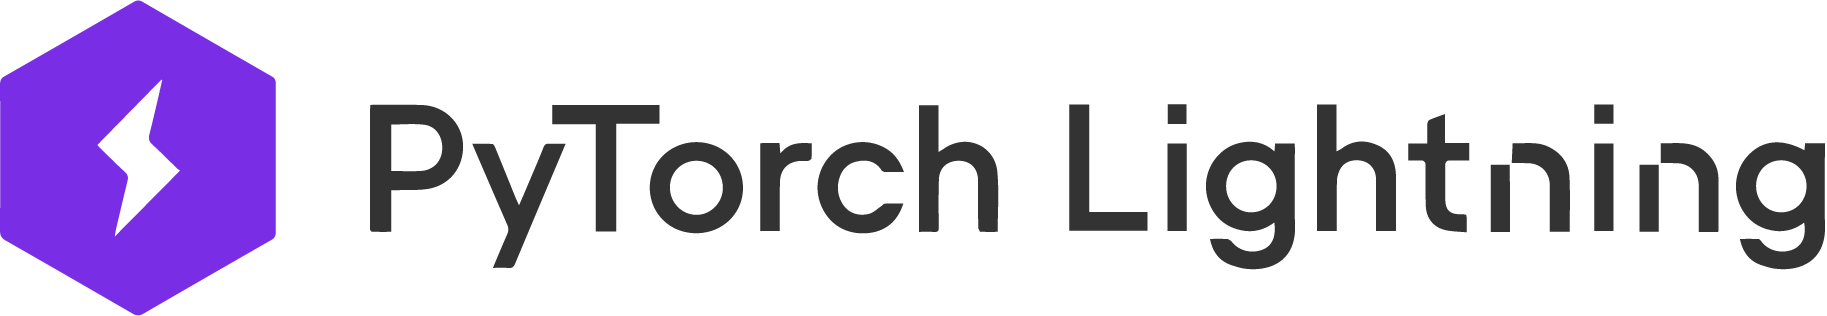{height="60px" width="240px"}](https://pytorchlightning.ai)